In [0]:
# ============================================================================
# INSTALLATION: PEFT + BITSANDBYTES
# ============================================================================

print("="*60)
print("INSTALLING QLORA DEPENDENCIES")
print("="*60)

# Install compatible versions
%pip install --upgrade \
    transformers==4.57.1 \
    accelerate==0.33.0 \
    peft==0.13.2 \
    bitsandbytes==0.48.0 \
    albumentations==1.3.1 \
    opencv-python-headless==4.8.1.78 \
    openpyxl==3.1.2 \
    scipy==1.11.4 \
    --quiet

print("\n✓ Installation complete!")
print("\n" + "="*60)
print("⚠️  RESTART KERNEL NOW!")
print("="*60)

INSTALLING QLORA DEPENDENCIES
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.

✓ Installation complete!

⚠️  RESTART KERNEL NOW!


In [0]:
%restart_python


## MODULE 0: CONFIGURATION & DATA LOADING

In [0]:
# ============================================================================
# IMPORTS
# ============================================================================

import os
import re
import json
import random
import time
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from tqdm import tqdm
import mlflow
import mlflow.pytorch

from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix,
    classification_report
)

# Transformers + PEFT for QLoRA
from transformers import AutoImageProcessor, AutoModel, BitsAndBytesConfig
from peft import (
    LoraConfig, 
    get_peft_model, 
    PeftModel,
    prepare_model_for_kbit_training
)

# Set random seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✓ All libraries imported")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ CUDA device: {torch.cuda.get_device_name(0)}")
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✓ GPU Memory: {total_mem:.2f} GB")

# ================== CONFIGURATION ==================
class Config:
    # Base paths
    BASE_DBFS = "dbfs:/mnt/playbehavior/Fine_tuning"
    
    # Metadata paths
    METADATA_A = f"{BASE_DBFS}/Verified Lables/mmcows.xlsx"
    METADATA_B = f"{BASE_DBFS}/Verified Lables/PlayBehavior.xlsx"
    
    # Cropped images directories
    MMCOWS_CROPS_DBFS = f"{BASE_DBFS}/mmcows/visual_data/visual_data/images/Cropped Images"
    PLAYBEHAVIOR_CROPS_DBFS = f"{BASE_DBFS}/Playbehavior"
    
    # Behavior labels
    MMCOWS_LABELS = ["Drinking", "Feeding head up", "Feeding head down", "Lying", "Standing", "Walking"]
    PLAYBEHAVIOR_LABELS = ["gallop", "leap", "frontal_pushing"]
    ALL_LABELS = MMCOWS_LABELS + PLAYBEHAVIOR_LABELS
    
    # Dataset parameters
    TRAIN_SAMPLES_PER_LABEL = 300
    AUGMENTED_SAMPLES_PER_LABEL = 900
    IMAGE_SIZE = 224
    
    # Verification priority
    VERIFICATION_PRIORITY = {1: 0, 3: 1, 2: 2}
    
    # Output paths for processed datasets
    OUTPUT_BASE = f"{BASE_DBFS}/Processed_Datasets"
    TRAIN_DATASET_PATH = f"{OUTPUT_BASE}/train_dataset.csv"
    TEST_MMCOWS_DATASET_PATH = f"{OUTPUT_BASE}/test_mmcows_dataset.csv"
    TEST_PLAYBEHAVIOR_DATASET_PATH = f"{OUTPUT_BASE}/test_playbehavior_dataset.csv"

# ================== UTILITY FUNCTIONS ==================
def dbfs_to_local(path: str) -> str:
    """Convert DBFS path to local /dbfs path"""
    if path.startswith("dbfs:/"):
        return "/dbfs" + path[5:]
    return path

def local_to_dbfs(path: str) -> str:
    """Convert local /dbfs path to DBFS URI"""
    if path.startswith("/dbfs/"):
        return "dbfs:" + path[5:]
    return path

def ensure_local_path(path: str) -> str:
    """Ensure path is in local /dbfs format"""
    if pd.isna(path) or not isinstance(path, str):
        return ""
    return dbfs_to_local(path)

def check_image_exists(path: str) -> bool:
    """Check if image file exists and is readable"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return False
    try:
        img = Image.open(local_path)
        img.verify()
        return True
    except:
        return False

def load_image_cv2(path: str) -> Optional[np.ndarray]:
    """Load image using OpenCV"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return None
    img = cv2.imread(local_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_image_pil(path: str) -> Optional[Image.Image]:
    """Load image using PIL"""
    local_path = ensure_local_path(path)
    if not local_path or not os.path.exists(local_path):
        return None
    try:
        return Image.open(local_path).convert('RGB')
    except:
        return None

print("✓ Configuration and utilities loaded")
print(f"  - Training samples per label: {Config.TRAIN_SAMPLES_PER_LABEL}")
print(f"  - Target augmented samples: {Config.AUGMENTED_SAMPLES_PER_LABEL}")
print(f"  - Total labels: {len(Config.ALL_LABELS)}")

# ================== RELOAD DATASETS ==================
print("="*60)
print("RELOADING ALL SAVED DATASETS")
print("="*60)

# Check if datasets exist
train_csv_path = dbfs_to_local(Config.TRAIN_DATASET_PATH)
mmcows_test_csv_path = dbfs_to_local(Config.TEST_MMCOWS_DATASET_PATH)
playbehavior_test_csv_path = dbfs_to_local(Config.TEST_PLAYBEHAVIOR_DATASET_PATH)

datasets_exist = {
    'train': os.path.exists(train_csv_path),
    'mmcows_test': os.path.exists(mmcows_test_csv_path),
    'playbehavior_test': os.path.exists(playbehavior_test_csv_path)
}

print("\n📂 Dataset Files Status:")
for name, exists in datasets_exist.items():
    status = "✓ Found" if exists else "✗ Missing"
    print(f"  {name:20s}: {status}")

if not all(datasets_exist.values()):
    raise FileNotFoundError("Some dataset files are missing! Please rerun Modules 1-4")

print("\n✓ All dataset files found! Loading...")

# Load Training Dataset
print("\n[1/3] Loading training dataset...")
train_df = pd.read_csv(train_csv_path)
print(f"  ✓ Loaded: {len(train_df):,} samples")
print(f"    - Labels: {sorted(train_df['label'].unique())}")
print(f"    - Sources: {train_df['source'].unique().tolist()}")

# Load MMcows Test Dataset
print("\n[2/3] Loading MMcows test dataset...")
mmcows_test_df = pd.read_csv(mmcows_test_csv_path)
print(f"  ✓ Loaded: {len(mmcows_test_df):,} samples")
print(f"    - Labels: {sorted(mmcows_test_df['label'].unique())}")

# Load PlayBehavior Test Dataset
print("\n[3/3] Loading PlayBehavior test dataset...")
playbehavior_test_df = pd.read_csv(playbehavior_test_csv_path)
print(f"  ✓ Loaded: {len(playbehavior_test_df):,} samples")
print(f"    - Labels: {sorted(playbehavior_test_df['label'].unique())}")

# Combine test datasets
combined_test_df = pd.concat([mmcows_test_df, playbehavior_test_df], ignore_index=True)
print(f"\n✓ Combined test dataset: {len(combined_test_df):,} samples")

print("\n" + "="*60)

# ================== QUICK VALIDATION ==================
print("="*60)
print("QUICK VALIDATION")
print("="*60)

train_paths = set(train_df['image_path'].values)
test_paths = set(combined_test_df['image_path'].values)
overlap = train_paths & test_paths

print(f"\n🔍 Train/Test Overlap Check:")
print(f"  - Training paths: {len(train_paths):,}")
print(f"  - Test paths: {len(test_paths):,}")
print(f"  - Overlap: {len(overlap):,}")

if len(overlap) == 0:
    print("  ✓ PASS: No overlap between train and test")
else:
    print("  ✗ FAIL: Found overlapping samples!")
    print(f"    First few overlaps: {list(overlap)[:5]}")

# Check label consistency
train_labels = set(train_df['label'].unique())
test_labels = set(combined_test_df['label'].unique())

print(f"\n🏷️  Label Consistency Check:")
print(f"  - Training labels: {len(train_labels)}")
print(f"  - Test labels: {len(test_labels)}")

if train_labels == test_labels:
    print("  ✓ PASS: Same labels in train and test")
else:
    missing_in_test = train_labels - test_labels
    missing_in_train = test_labels - train_labels
    if missing_in_test:
        print(f"  ⚠️  Labels in train but not test: {missing_in_test}")
    if missing_in_train:
        print(f"  ⚠️  Labels in test but not train: {missing_in_train}")

print("\n" + "="*60)
print("✓ VALIDATION COMPLETE")
print("="*60)

# ================== CREATE TRAIN/VAL SPLIT (80/20) ==================
print("="*60)
print("CREATING TRAIN/VALIDATION SPLIT (80/20)")
print("="*60)

from sklearn.model_selection import train_test_split

# Stratified split to maintain class balance
train_split_df, val_split_df = train_test_split(
    train_df,
    test_size=0.2,  # 20% for validation
    stratify=train_df['label'],
    random_state=42
)

print(f"Original training set: {len(train_df)} samples")
print(f"  → Train split: {len(train_split_df)} samples (240 per class)")
print(f"  → Val split: {len(val_split_df)} samples (60 per class)")

print("\nTrain split distribution:")
for label, count in train_split_df['label'].value_counts().sort_index().items():
    print(f"  {label:25s}: {count:3d}")

print("\nValidation split distribution:")
for label, count in val_split_df['label'].value_counts().sort_index().items():
    print(f"  {label:25s}: {count:3d}")

# Save splits to CSV
train_split_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/train_split.csv")
val_split_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/val_split.csv")

train_split_df.to_csv(train_split_path, index=False)
val_split_df.to_csv(val_split_path, index=False)

print(f"\n✓ Saved train split: {local_to_dbfs(train_split_path)}")
print(f"✓ Saved val split: {local_to_dbfs(val_split_path)}")
print("="*60)

2025-11-30 17:06:12.687135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ All libraries imported
✓ PyTorch version: 2.3.1+cu121
✓ CUDA available: True
✓ CUDA device: Tesla V100-PCIE-16GB
✓ GPU Memory: 15.77 GB
✓ Configuration and utilities loaded
  - Training samples per label: 300
  - Target augmented samples: 900
  - Total labels: 9
RELOADING ALL SAVED DATASETS

📂 Dataset Files Status:
  train               : ✓ Found
  mmcows_test         : ✓ Found
  playbehavior_test   : ✓ Found

✓ All dataset files found! Loading...

[1/3] Loading training dataset...
  ✓ Loaded: 2,700 samples
    - Labels: ['Drinking', 'Feeding head down', 'Feeding head up', 'Lying', 'Standing', 'Walking', 'frontal_pushing', 'gallop', 'leap']
    - Sources: ['mmcows', 'playbehavior']

[2/3] Loading MMcows test dataset...
  ✓ Loaded: 209,881 samples
    - Labels: ['Drinking', 'Feeding head down', 'Feeding head up', 'Lying', 'Standing', 'Walking']

[3/3] Loading PlayBehavior test dataset...
  ✓ Loaded: 1,919 samples
    - Labels: ['frontal_pushing', 'gallop', 'leap']

✓ Combined test dat

## MODULE 5: AUGMENTATION PIPELINE

In [0]:
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from typing import Optional, Tuple, Dict, Any

class AugmentationPipeline:
    """
    Comprehensive augmentation pipeline for cow behavior images
    Uses albumentations for diverse and efficient augmentation
    """
    
    def __init__(self, 
                 image_size: int = 224,
                 mode: str = 'train',
                 augmentation_strength: str = 'medium'):
        """
        Args:
            image_size: Target image size (default 224 for most models)
            mode: 'train', 'val', or 'test'
            augmentation_strength: 'light', 'medium', or 'heavy'
        """
        self.image_size = image_size
        self.mode = mode
        self.augmentation_strength = augmentation_strength
        
        # Build augmentation pipeline based on mode
        if mode == 'train':
            self.transform = self._build_train_transform()
        else:
            self.transform = self._build_eval_transform()
    
    def _build_train_transform(self) -> A.Compose:
        """Build training augmentation pipeline"""
        
        # Define augmentation strength parameters
        if self.augmentation_strength == 'light':
            brightness_limit = 0.1
            contrast_limit = 0.1
            rotation_limit = 10
            scale_range = (0.9, 1.1)
        elif self.augmentation_strength == 'medium':
            brightness_limit = 0.2
            contrast_limit = 0.2
            rotation_limit = 15
            scale_range = (0.8, 1.2)
        else:  # heavy
            brightness_limit = 0.3
            contrast_limit = 0.3
            rotation_limit = 20
            scale_range = (0.7, 1.3)
        
        transform = A.Compose([
            # Geometric transformations
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=rotation_limit, p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=(scale_range[0]-1, scale_range[1]-1),
                rotate_limit=rotation_limit,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                p=0.5
            ),
            A.Perspective(scale=(0.05, 0.1), p=0.3),
            
            # Color transformations
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=brightness_limit,
                    contrast_limit=contrast_limit,
                    p=1.0
                ),
                A.HueSaturationValue(
                    hue_shift_limit=10,
                    sat_shift_limit=20,
                    val_shift_limit=20,
                    p=1.0
                ),
                A.ColorJitter(
                    brightness=brightness_limit,
                    contrast=contrast_limit,
                    saturation=0.2,
                    hue=0.1,
                    p=1.0
                ),
            ], p=0.8),
            
            # Noise and blur
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
                A.GaussianBlur(blur_limit=(3, 5), p=1.0),
                A.MotionBlur(blur_limit=5, p=1.0),
            ], p=0.3),
            
            # Advanced augmentations
            A.CoarseDropout(
                max_holes=8,
                max_height=int(0.1 * self.image_size),
                max_width=int(0.1 * self.image_size),
                min_holes=1,
                fill_value=0,
                p=0.2
            ),
            
            # Resize and normalize
            A.Resize(self.image_size, self.image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet stats
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        
        return transform
    
    def _build_eval_transform(self) -> A.Compose:
        """Build evaluation (validation/test) transform - no augmentation"""
        transform = A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        
        return transform
    
    def __call__(self, image: np.ndarray) -> torch.Tensor:
        """
        Apply transformation to image
        
        Args:
            image: numpy array in RGB format (H, W, C)
        
        Returns:
            Transformed image as PyTorch tensor
        """
        if not isinstance(image, np.ndarray):
            raise TypeError(f"Expected numpy array, got {type(image)}")
        
        # Ensure image is in correct format
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
        
        # Apply transformations
        transformed = self.transform(image=image)
        return transformed['image']
    
    def get_params_summary(self) -> Dict[str, Any]:
        """Get summary of augmentation parameters"""
        return {
            'mode': self.mode,
            'image_size': self.image_size,
            'augmentation_strength': self.augmentation_strength,
            'num_transforms': len(self.transform.transforms) if hasattr(self.transform, 'transforms') else 0
        }


print("="*60)
print("AUGMENTATION PIPELINE")
print("="*60)

# Create pipelines for different modes
train_aug = AugmentationPipeline(image_size=224, mode='train', augmentation_strength='medium')
test_aug = AugmentationPipeline(image_size=224, mode='test')

print("\n✓ Training augmentation pipeline:")
print(f"  - Image size: {train_aug.image_size}")
print(f"  - Mode: {train_aug.mode}")
print(f"  - Strength: {train_aug.augmentation_strength}")
print(f"  - Transforms: {len(train_aug.transform.transforms)}")

print("\n✓ Test/validation pipeline:")
print(f"  - Image size: {test_aug.image_size}")
print(f"  - Mode: {test_aug.mode}")
print(f"  - Transforms: {len(test_aug.transform.transforms)} (resize + normalize only)")

print("\n" + "="*60)
print("Ready for dataset integration!")
print("="*60)

AUGMENTATION PIPELINE

✓ Training augmentation pipeline:
  - Image size: 224
  - Mode: train
  - Strength: medium
  - Transforms: 10

✓ Test/validation pipeline:
  - Image size: 224
  - Mode: test
  - Transforms: 3 (resize + normalize only)

Ready for dataset integration!


## MODULE 6: PYTORCH DATASET & DATALOADER (UPDATED FOR 3× AUGMENTATION)

In [0]:

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from typing import Optional, Callable, Dict, Tuple
import pandas as pd
from collections import Counter

class CowBehaviorDataset(Dataset):
    """
    Dataset with on-the-fly 3× augmentation for training:
    - Returns 3 versions: original + 2 augmented
    - Effectively 3× the dataset size
    """
    
    def __init__(self,
                 metadata_df: pd.DataFrame,
                 transform: Optional[Callable] = None,
                 image_size: int = 224,
                 mode: str = 'train',
                 augmentation_strength: str = 'medium',
                 label_to_idx: Optional[Dict[str, int]] = None,
                 augmentation_multiplier: int = 3):
        """
        Args:
            augmentation_multiplier: Number of versions per image (1=original only, 3=original+2 augmented)
        """
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.image_size = image_size
        self.mode = mode
        # self.augmentation_multiplier = augmentation_multiplier if mode == 'train' else 1
        self.augmentation_multiplier = augmentation_multiplier

        # Create label mapping
        if label_to_idx is None:
            unique_labels = sorted(self.metadata_df['label'].unique())
            self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        else:
            self.label_to_idx = label_to_idx
        
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)
        
        # # Setup transforms
        # # For training: need both non-augmented (for original) and augmented transforms
        # if mode == 'train':
        #     self.transform_original = AugmentationPipeline(
        #         image_size=image_size,
        #         mode='test',  # No augmentation for "original" version
        #         augmentation_strength=augmentation_strength
        #     )
        #     self.transform_augmented = AugmentationPipeline(
        #         image_size=image_size,
        #         mode='train',  # With augmentation
        #         augmentation_strength=augmentation_strength
        #     )
        # else:
        #     # Val/test: no augmentation
        #     if transform is not None:
        #         self.transform_original = transform
        #     else:
        #         self.transform_original = AugmentationPipeline(
        #             image_size=image_size,
        #             mode='test'
        #         )
                
        # Setup transforms
        # For training or augmented validation:
        if mode == 'train' or (mode == 'val' and self.augmentation_multiplier > 1):
            self.transform_original = AugmentationPipeline(
                image_size=image_size,
                mode='test',  # No augmentation for "original" version
                augmentation_strength=augmentation_strength
            )
            self.transform_augmented = AugmentationPipeline(
                image_size=image_size,
                mode='train',  # With augmentation
                augmentation_strength=augmentation_strength
            )
        else:
            # Standard val/test: no augmentation
            if transform is not None:
                self.transform_original = transform
            else:
                self.transform_original = AugmentationPipeline(
                    image_size=image_size,
                    mode='test'
                )
        
        # Cache for failed image loads
        self._failed_indices = set()
        
        print(f"[{mode.upper()} Dataset] Initialized")
        print(f"  - Physical samples: {len(self.metadata_df)}")
        print(f"  - Augmentation multiplier: {self.augmentation_multiplier}×")
        print(f"  - Effective samples: {len(self)} (what DataLoader sees)")
        print(f"  - Number of classes: {self.num_classes}")
    
    def __len__(self) -> int:
        """
        Return effective dataset size (physical samples × augmentation multiplier)
        This makes DataLoader iterate through all augmented versions
        """
        return len(self.metadata_df) * self.augmentation_multiplier
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, Dict]:
        """
        Get item by index
        
        For training with augmentation_multiplier=3:
        - idx 0, 1, 2 → same image (idx 0), different augmentations
        - idx 3, 4, 5 → same image (idx 1), different augmentations
        
        Returns:
            image: Transformed image tensor (C, H, W)
            label: Label index
            metadata: Dictionary with additional info
        """
        # Map augmented index to physical sample index
        physical_idx = idx // self.augmentation_multiplier
        augmentation_idx = idx % self.augmentation_multiplier
        
        if physical_idx in self._failed_indices:
            # Return a random valid index if this one previously failed
            new_idx = np.random.randint(0, len(self))
            return self.__getitem__(new_idx)
        
        try:
            row = self.metadata_df.iloc[physical_idx]
            
            # Load image
            image_path = row['image_path']
            image = load_image_cv2(image_path)  # Returns RGB numpy array
            
            if image is None:
                self._failed_indices.add(physical_idx)
                # Fallback to random valid sample
                return self.__getitem__(np.random.randint(0, len(self)))
            
            # Get label
            label_str = row['label']
            label_idx = self.label_to_idx[label_str]
            
            # Apply transforms based on augmentation index
            # if self.mode == 'train':
            #     if augmentation_idx == 0:
            #         # Original (no augmentation)
            #         image_tensor = self.transform_original(image)
            #     else:
            #         # Augmented versions
            #         image_tensor = self.transform_augmented(image)
            # else:
            #     # Val/test: always use original transform
            #     image_tensor = self.transform_original(image)
            
            # Apply transforms based on augmentation index
            if self.mode == 'train' or (self.mode == 'val' and self.augmentation_multiplier > 1):
                if augmentation_idx == 0:
                    # Original (no augmentation)
                    image_tensor = self.transform_original(image)
                else:
                    # Augmented versions
                    image_tensor = self.transform_augmented(image)
            else:
                # Standard Val/test: always use original transform
                image_tensor = self.transform_original(image)

            # Metadata
            metadata = {
                'idx': idx,
                'physical_idx': physical_idx,
                'augmentation_idx': augmentation_idx,
                'image_path': image_path,
                'label_str': label_str,
                'label_idx': label_idx,
                'source': row.get('source', 'unknown'),
                'cow_id': row.get('cow_id', -1),
            }
            
            return image_tensor, label_idx, metadata
        
        except Exception as e:
            print(f"Error loading sample {idx} (physical {physical_idx}): {e}")
            self._failed_indices.add(physical_idx)
            # Return random valid sample
            return self.__getitem__(np.random.randint(0, len(self)))
    
    def get_label_distribution(self) -> Dict[str, int]:
        """Get distribution of labels in physical dataset"""
        return dict(Counter(self.metadata_df['label']))
    
    def get_class_weights(self) -> torch.Tensor:
        """
        Calculate class weights for balanced training
        Based on physical dataset (not augmented count)
        """
        label_counts = self.metadata_df['label'].value_counts()
        total_samples = len(self.metadata_df)
        
        # Calculate weights (inverse frequency)
        weights = []
        for label in sorted(self.label_to_idx.keys()):
            count = label_counts.get(label, 1)
            weight = total_samples / (len(label_counts) * count)
            weights.append(weight)
        
        return torch.FloatTensor(weights)
    
    def get_sample_weights(self) -> torch.Tensor:
        """
        Get per-sample weights for WeightedRandomSampler
        Returns weights for EFFECTIVE dataset size (with augmentation)
        """
        class_weights = self.get_class_weights()
        sample_weights = []
        
        for _ in range(self.augmentation_multiplier):
            for _, row in self.metadata_df.iterrows():
                label_idx = self.label_to_idx[row['label']]
                sample_weights.append(class_weights[label_idx].item())
        
        return torch.FloatTensor(sample_weights)


def create_dataloaders(train_df: pd.DataFrame,
                       val_df: pd.DataFrame,
                       test_df: Optional[pd.DataFrame] = None,
                       batch_size: int = 32,
                       num_workers: int = 4,
                       image_size: int = 224,
                       use_weighted_sampling: bool = False,
                       augmentation_strength: str = 'medium',
                       augmentation_multiplier: int = 3, val_augmentation_multiplier: int = 1) -> Dict[str, DataLoader]:
    """
    Create PyTorch DataLoaders with 3× augmentation for training
    
    Args:
        train_df: Training metadata DataFrame (will be augmented 3×)
        val_df: Validation metadata DataFrame (no augmentation)
        test_df: Test metadata DataFrame (optional, no augmentation)
        augmentation_multiplier: Number of versions per training image (3 = 900 total)
    """
    
    # Create label mapping from all data
    all_labels = set(train_df['label'].unique())
    all_labels.update(val_df['label'].unique())
    if test_df is not None:
        all_labels.update(test_df['label'].unique())
    
    label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
    
    # Create training dataset (with 3× augmentation)
    train_dataset = CowBehaviorDataset(
        train_df,
        image_size=image_size,
        mode='train',
        augmentation_strength=augmentation_strength,
        label_to_idx=label_to_idx,
        augmentation_multiplier=augmentation_multiplier
    )
    
    # Setup sampler for training
    if use_weighted_sampling:
        sample_weights = train_dataset.get_sample_weights()
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        shuffle = False
        print("✓ Using WeightedRandomSampler for balanced training")
    else:
        sampler = None
        shuffle = True
    
    # Training dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    dataloaders = {'train': train_loader}
    
    # # Validation dataloader (NO augmentation)
    # val_dataset = CowBehaviorDataset(
    #     val_df,
    #     image_size=image_size,
    #     mode='val',
    #     label_to_idx=label_to_idx,
    #     augmentation_multiplier=1
    # )
    # Validation dataloader (NOW with controllable augmentation)
    val_dataset = CowBehaviorDataset(
        val_df,
        image_size=image_size,
        mode='val',
        augmentation_strength=augmentation_strength, # Pass strength
        label_to_idx=label_to_idx,
        augmentation_multiplier=val_augmentation_multiplier # Use new param
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    dataloaders['val'] = val_loader
    
    # Test dataloader (if provided)
    if test_df is not None:
        test_dataset = CowBehaviorDataset(
            test_df,
            image_size=image_size,
            mode='test',
            label_to_idx=label_to_idx,
            augmentation_multiplier=1
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
        dataloaders['test'] = test_loader
    
    return dataloaders


print("="*60)
print("✓ UPDATED DATASET CLASS (3× AUGMENTATION)")
print("="*60)
print("Changes:")
print("  - __len__() returns physical_samples × augmentation_multiplier")
print("  - __getitem__() returns original (idx 0, 3, 6...) or augmented (idx 1,2,4,5...)")
print("  - Training sees 900 samples per class (300 physical × 3)")
print("="*60)

✓ UPDATED DATASET CLASS (3× AUGMENTATION)
Changes:
  - __len__() returns physical_samples × augmentation_multiplier
  - __getitem__() returns original (idx 0, 3, 6...) or augmented (idx 1,2,4,5...)
  - Training sees 900 samples per class (300 physical × 3)


## MODULE 7: VALIDATION & VISUALIZATION

In [0]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from typing import List
import torch

class DatasetValidator:
    """
    Validate and visualize datasets before training
    """
    
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        self.train_df = train_df
        self.test_df = test_df
    
    def print_statistics(self):
        """Print comprehensive dataset statistics"""
        print("="*60)
        print("DATASET STATISTICS")
        print("="*60)
        
        print("\n📊 TRAINING SET")
        print("-" * 60)
        print(f"Total samples: {len(self.train_df)}")
        print(f"Number of labels: {self.train_df['label'].nunique()}")
        print(f"Sources: {self.train_df['source'].unique()}")
        
        print("\nSamples per label:")
        for label, count in self.train_df['label'].value_counts().sort_index().items():
            print(f"  {label:25s}: {count:4d}")
        
        print("\nSamples per source:")
        for source, count in self.train_df['source'].value_counts().items():
            print(f"  {source:15s}: {count:4d}")
        
        if 'Verification' in self.train_df.columns:
            print("\nVerification distribution:")
            for ver, count in self.train_df['Verification'].value_counts().sort_index().items():
                pct = 100 * count / len(self.train_df)
                print(f"  Verification {ver}: {count:4d} ({pct:.1f}%)")
        
        print("\n" + "="*60)
        print("📊 TEST SET")
        print("-" * 60)
        print(f"Total samples: {len(self.test_df)}")
        print(f"Number of labels: {self.test_df['label'].nunique()}")
        print(f"Sources: {self.test_df['source'].unique()}")
        
        print("\nSamples per label:")
        for label, count in self.test_df['label'].value_counts().sort_index().items():
            train_count = len(self.train_df[self.train_df['label'] == label])
            ratio = count / train_count if train_count > 0 else 0
            print(f"  {label:25s}: {count:6d} (train:test = 1:{ratio:.1f})")
        
        print("\nSamples per source:")
        for source, count in self.test_df['source'].value_counts().items():
            print(f"  {source:15s}: {count:6d}")
    
    def plot_label_distribution(self, figsize=(14, 6)):
        """Plot label distribution for train and test sets"""
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Training set
        train_counts = self.train_df['label'].value_counts().sort_index()
        axes[0].bar(range(len(train_counts)), train_counts.values, color='steelblue', alpha=0.7)
        axes[0].set_xticks(range(len(train_counts)))
        axes[0].set_xticklabels(train_counts.index, rotation=45, ha='right')
        axes[0].set_ylabel('Count')
        axes[0].set_title(f'Training Set Distribution\n(Total: {len(self.train_df)} samples)')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Test set
        test_counts = self.test_df['label'].value_counts().sort_index()
        axes[1].bar(range(len(test_counts)), test_counts.values, color='coral', alpha=0.7)
        axes[1].set_xticks(range(len(test_counts)))
        axes[1].set_xticklabels(test_counts.index, rotation=45, ha='right')
        axes[1].set_ylabel('Count')
        axes[1].set_title(f'Test Set Distribution\n(Total: {len(self.test_df)} samples)')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def check_data_integrity(self) -> Dict[str, bool]:
        """Check data integrity and return status"""
        checks = {}
        
        # Check 1: No overlap between train and test
        train_paths = set(self.train_df['image_path'])
        test_paths = set(self.test_df['image_path'])
        overlap = train_paths & test_paths
        checks['no_overlap'] = len(overlap) == 0
        
        if not checks['no_overlap']:
            print(f"⚠️  WARNING: {len(overlap)} samples appear in both train and test!")
        else:
            print("✓ No overlap between train and test sets")
        
        # Check 2: All labels present in both sets
        train_labels = set(self.train_df['label'])
        test_labels = set(self.test_df['label'])
        checks['labels_match'] = train_labels == test_labels
        
        if not checks['labels_match']:
            missing_in_test = train_labels - test_labels
            missing_in_train = test_labels - train_labels
            if missing_in_test:
                print(f"⚠️  WARNING: Labels in train but not test: {missing_in_test}")
            if missing_in_train:
                print(f"⚠️  WARNING: Labels in test but not train: {missing_in_train}")
        else:
            print("✓ All labels present in both train and test sets")
        
        # Check 3: Reasonable train/test split ratios
        checks['reasonable_splits'] = True
        for label in train_labels:
            train_count = len(self.train_df[self.train_df['label'] == label])
            test_count = len(self.test_df[self.test_df['label'] == label])
            if test_count == 0:
                print(f"⚠️  WARNING: Label '{label}' has no test samples!")
                checks['reasonable_splits'] = False
        
        if checks['reasonable_splits']:
            print("✓ All labels have test samples")
        
        return checks


def visualize_augmentations(dataset: CowBehaviorDataset, 
                            num_samples: int = 3,
                            num_augmentations: int = 5,
                            figsize=(15, 10)):
    """
    Visualize augmentation effects on random samples
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(num_samples, num_augmentations + 1, figure=fig)
    
    # Denormalize function
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)
        return tensor.permute(1, 2, 0).numpy()
    
    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Get original image (without augmentation)
        row = dataset.metadata_df.iloc[idx]
        original_img = load_image_cv2(row['image_path'])
        label = row['label']
        
        # Show original
        ax = fig.add_subplot(gs[i, 0])
        ax.imshow(original_img)
        ax.set_title(f'Original\n{label}', fontsize=10)
        ax.axis('off')
        
        # Show augmented versions
        for j in range(num_augmentations):
            img_tensor, _, _ = dataset[idx]
            img_np = denormalize(img_tensor)
            
            ax = fig.add_subplot(gs[i, j + 1])
            ax.imshow(img_np)
            ax.set_title(f'Aug {j+1}', fontsize=10)
            ax.axis('off')
    
    plt.suptitle('Augmentation Visualization (Original + 5 Random Augmentations)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def test_dataloader_speed(dataloader: DataLoader, num_batches: int = 10):
    """Test dataloader speed"""
    import time
    
    print(f"\n{'='*60}")
    print(f"DATALOADER SPEED TEST")
    print(f"{'='*60}")
    print(f"Batch size: {dataloader.batch_size}")
    print(f"Num workers: {dataloader.num_workers}")
    print(f"Testing {num_batches} batches...")
    
    times = []
    start = time.time()
    
    for i, (images, labels, metadata) in enumerate(dataloader):
        batch_time = time.time()
        
        if i > 0:  # Skip first batch (warmup)
            times.append(batch_time - prev_time)
        
        prev_time = batch_time
        
        if i >= num_batches:
            break
    
    total_time = time.time() - start
    avg_time = np.mean(times) if times else 0
    
    print(f"\nResults:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Average time per batch: {avg_time*1000:.1f}ms")
    print(f"  Throughput: {dataloader.batch_size / avg_time:.1f} images/sec")
    print(f"{'='*60}\n")


print("="*60)
print("VALIDATION & VISUALIZATION TOOLS")
print("="*60)
print("✓ DatasetValidator class")
print("✓ Augmentation visualization")
print("✓ Dataloader speed testing")
print("="*60)

VALIDATION & VISUALIZATION TOOLS
✓ DatasetValidator class
✓ Augmentation visualization
✓ Dataloader speed testing


In [0]:


# ============================================================================
# MODULES 0-7: REUSE FROM APPROACH 2
# ============================================================================
# NOTE: Run these cells from Approach 2:
# - Module 0: Config + Data Loading
# - Module 5: Augmentation Pipeline  
# - Module 6: Dataset & DataLoader
# - Module 7: Validation & Visualization

print("\n" + "="*60)
print("PREREQUISITES CHECK")
print("="*60)

try:
    # Check if prerequisites are loaded
    _ = Config.ALL_LABELS
    _ = combined_test_df
    _ = train_split_df
    _ = val_split_df
    _ = AugmentationPipeline
    _ = create_dataloaders
    print("✓ All prerequisites loaded")
    print(f"  - Config: {len(Config.ALL_LABELS)} labels")
    print(f"  - Train split: {len(train_split_df)} samples")
    print(f"  - Val split: {len(val_split_df)} samples")
    print(f"  - Test data: {len(combined_test_df)} samples")
except NameError as e:
    print(f"❌ Missing prerequisite: {e}")
    print("\nPlease run these modules from Approach 2:")
    print("  - Module 0: Config + Data Loading")
    print("  - Module 5: Augmentation Pipeline")
    print("  - Module 6: Dataset & DataLoader")
    print("  - Module 7: Validation (optional)")
    raise

print("="*60)


PREREQUISITES CHECK
✓ All prerequisites loaded
  - Config: 9 labels
  - Train split: 2160 samples
  - Val split: 540 samples
  - Test data: 211800 samples


In [0]:
"""
APPROACH 3: DINOV3 + QLORA FINE-TUNING

Fine-tunes the entire DINOv3 backbone using QLoRA for parameter-efficient training.
Reuses data loading and augmentation from Approaches 1 & 2.

Key Features:
- QLoRA with r=16 (1.5% trainable parameters)
- 4-bit quantization for memory efficiency
- Gradient checkpointing
- Saves LoRA adapters only (400MB vs 13.5GB)
- Merges adapters at evaluation time
"""

# ============================================================================
# VERIFY PEFT & BITSANDBYTES
# ============================================================================

print("\n" + "="*60)
print("VERIFYING QLORA DEPENDENCIES")
print("="*60)

try:
    import peft
    import bitsandbytes as bnb
    print(f"✓ PEFT version: {peft.__version__}")
    print(f"✓ bitsandbytes version: {bnb.__version__}")
    print("✓ All QLoRA dependencies ready")
except ImportError as e:
    print(f"❌ Missing dependency: {e}")
    print("Please run the installation cell and restart kernel!")
    raise

print("="*60)


VERIFYING QLORA DEPENDENCIES
✓ PEFT version: 0.13.2
✓ bitsandbytes version: 0.48.0
✓ All QLoRA dependencies ready


## MODULE 8: DINOV3 + QLORA ARCHITECTURE

In [0]:
# ============================================================================
# MODULE 8: DINOV3 + QLORA (SIMPLIFIED - ALL LINEAR LAYERS)
# ============================================================================

print("\n" + "="*60)
print("MODULE 8: DINOV3 + QLORA ARCHITECTURE")
print("="*60)


class QLoRAConfig:
    """QLoRA configuration for DINOv3 fine-tuning"""
    
    # LoRA hyperparameters
    LORA_R = 16
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.05
    
    # Target some linear layers (recommended for DINOv3)
    TARGET_MODULES = "all-linear"
    
    # 4-bit quantization config
    USE_4BIT = True
    BNB_4BIT_COMPUTE_DTYPE = torch.float16
    BNB_4BIT_QUANT_TYPE = "nf4"
    BNB_4BIT_USE_DOUBLE_QUANT = True
    
    # Training config
    BIAS = "none"
    TASK_TYPE = "FEATURE_EXTRACTION"


print(f"QLoRA Configuration:")
print(f"  - Rank (r): {QLoRAConfig.LORA_R}")
print(f"  - Alpha: {QLoRAConfig.LORA_ALPHA}")
print(f"  - Dropout: {QLoRAConfig.LORA_DROPOUT}")
print(f"  - Target modules: {QLoRAConfig.TARGET_MODULES} (Limited layers)")
print(f"  - Quantization: 4-bit ({QLoRAConfig.BNB_4BIT_QUANT_TYPE})")


class DINOv3WithQLoRA(nn.Module):
    """
    DINOv3 with QLoRA adapters + Classification head
    
    Architecture:
    - DINOv3 backbone: 4-bit quantized + LoRA adapters (trainable)
    - Classifier head: Fully trainable
    
    Memory usage: ~11-13GB (depends on exact adapter count)
    Trainable params: ~150M (2.2% of total) with all-linear
    """
    
    def __init__(self, 
                 num_classes: int = 9,
                 hidden_dim: int = 1024,
                 dropout_rate: float = 0.3,
                 model_name: str = "facebook/dinov3-vit7b16-pretrain-lvd1689m"):
        super(DINOv3WithQLoRA, self).__init__()
        
        print("\nCreating DINOv3 with QLoRA...")
        print("This will take 5-10 minutes (loading 6.7B parameters)...")
        
        # Clear cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # ============================================================
        # STEP 1: Create quantization config
        # ============================================================
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=QLoRAConfig.USE_4BIT,
            bnb_4bit_compute_dtype=QLoRAConfig.BNB_4BIT_COMPUTE_DTYPE,
            bnb_4bit_quant_type=QLoRAConfig.BNB_4BIT_QUANT_TYPE,
            bnb_4bit_use_double_quant=QLoRAConfig.BNB_4BIT_USE_DOUBLE_QUANT,
        )
        
        print("\n[Step 1/4] Loading DINOv3 with 4-bit quantization...")
        
        # ============================================================
        # STEP 2: Load base model with quantization
        # ============================================================
        self.model = AutoModel.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True
        )
        
        print("✓ DINOv3 loaded with 4-bit quantization")
        
        # ============================================================
        # STEP 3: Prepare model for k-bit training
        # ============================================================
        print("\n[Step 2/4] Preparing model for QLoRA training...")
        self.model = prepare_model_for_kbit_training(self.model)
        
        # ============================================================
        # STEP 4: Add LoRA adapters with "only part of the layers"
        # ============================================================
        print("\n[Step 3/4] Adding LoRA adapters to only part of the layers...")
        
        lora_config = LoraConfig(
            r=QLoRAConfig.LORA_R,
            lora_alpha=QLoRAConfig.LORA_ALPHA,
            target_modules=QLoRAConfig.TARGET_MODULES,  
            lora_dropout=QLoRAConfig.LORA_DROPOUT,
            bias=QLoRAConfig.BIAS,
            task_type=QLoRAConfig.TASK_TYPE
        )
        
        self.model = get_peft_model(self.model, lora_config)
        
        print("✓ LoRA adapters added to some layers")
        self.model.print_trainable_parameters()
        
        # ============================================================
        # STEP 5: Create classifier head
        # ============================================================
        print("\n[Step 4/4] Creating classification head...")
        
        self.embedding_dim = self.model.config.hidden_size  # 4096
        
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        # Initialize classifier weights
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
        # Move classifier to same device as model
        self.device = next(self.model.parameters()).device
        self.classifier = self.classifier.to(self.device)
        
        self.num_classes = num_classes
        self.num_features = self.embedding_dim
        
        print(f"✓ Classifier created and moved to {self.device}")
        
        # ============================================================
        # Summary
        # ============================================================
        print(f"\n{'='*60}")
        print("MODEL SUMMARY")
        print(f"{'='*60}")
        
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        lora_params = sum(p.numel() for n, p in self.model.named_parameters() if 'lora' in n)
        classifier_params = sum(p.numel() for p in self.classifier.parameters())
        
        print(f"Total parameters: {total_params:,} ({total_params/1e9:.2f}B)")
        print(f"Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")
        print(f"  - LoRA adapters: {lora_params:,} ({lora_params/1e6:.2f}M)")
        print(f"  - Classifier: {classifier_params:,} ({classifier_params/1e6:.2f}M)")
        print(f"Trainable percentage: {100 * trainable_params / total_params:.3f}%")
        print(f"Device: {self.device}")
        
        # Memory usage
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(0) / 1024**3
            reserved = torch.cuda.memory_reserved(0) / 1024**3
            free = (torch.cuda.get_device_properties(0).total_memory - reserved) / 1024**3
            
            print(f"\nGPU Memory:")
            print(f"  - Allocated: {allocated:.2f} GB")
            print(f"  - Reserved: {reserved:.2f} GB")
            print(f"  - Free: {free:.2f} GB")
            
            if free < 3.0:
                print(f"  ⚠️  Low memory! Consider reducing batch size.")
        
        print(f"{'='*60}\n")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through QLoRA model + classifier"""
        if x.device != self.device:
            x = x.to(self.device)
        
        # Denormalize for DINOv3 (expects [0, 1])
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
        x_denorm = x * std + mean
        x_denorm = torch.clamp(x_denorm, 0, 1)
        
        # Extract features through QLoRA model
        outputs = self.model(pixel_values=x_denorm)
        features = outputs.pooler_output.float()
        
        # Classify
        logits = self.classifier(features)
        
        return logits
    
    def get_embeddings(self, x: torch.Tensor) -> torch.Tensor:
        """Extract embeddings (for analysis)"""
        if x.device != self.device:
            x = x.to(self.device)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
        x_denorm = x * std + mean
        x_denorm = torch.clamp(x_denorm, 0, 1)
        
        with torch.no_grad():
            outputs = self.model(pixel_values=x_denorm)
            features = outputs.pooler_output
        
        return features
    
    def save_lora_adapters(self, save_path: str):
        """Save only LoRA adapters (not full model)"""
        os.makedirs(save_path, exist_ok=True)
        self.model.save_pretrained(save_path)
        print(f"✓ LoRA adapters saved to: {save_path}")
    
    def save_classifier(self, save_path: str):
        """Save classifier weights"""
        torch.save(self.classifier.state_dict(), save_path)
        print(f"✓ Classifier saved to: {save_path}")


def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


print("✓ QLoRA architecture classes defined on only part of the layers")
print("\n" + "="*60)


MODULE 8: DINOV3 + QLORA ARCHITECTURE
QLoRA Configuration:
  - Rank (r): 16
  - Alpha: 32
  - Dropout: 0.05
  - Target modules: all-linear (Limited layers)
  - Quantization: 4-bit (nf4)
✓ QLoRA architecture classes defined on only part of the layers



## MODULE 9: TRAINING CONFIGURATION & TRAINER

In [0]:
print("\n" + "="*60)
print("MODULE 9: TRAINING CONFIGURATION & TRAINER")
print("="*60)


class QLoRATrainingConfig:
    """Training configuration optimized for QLoRA on V100 16GB"""
    
    # Model settings
    MODEL_NAME = 'dinov3_qlora_valx1_Alllinear'
    NUM_CLASSES = 9
    HIDDEN_DIM = 1024
    DROPOUT_RATE = 0.5
    
    # QLoRA settings
    LORA_R = 16
    LORA_ALPHA = 32 # or 16 for regularization
    LORA_DROPOUT = 0.05
    
    # Training settings (optimized for V100 16GB)
    EPOCHS = 80                        # Fewer epochs (fine-tuning)
    BATCH_SIZE = 4                     # Small batch (more params training)
    GRADIENT_ACCUMULATION_STEPS = 8    # Effective batch = 32
    LEARNING_RATE = 1e-4               # Standard for LoRA
    WEIGHT_DECAY = 0.01
    USE_MIXED_PRECISION = True
    
    # Learning rate schedule
    WARMUP_RATIO = 0.03                # 3% warmup
    SCHEDULER_TYPE = 'cosine'
    MIN_LR_RATIO = 0.1                 # Min LR = 10% of max
    
    # Augmentation (same as Approaches 1 & 2)
    AUGMENTATION_MULTIPLIER = 3
    VAL_AUGMENTATION_MULTIPLIER = 1
    AUGMENTATION_STRENGTH = 'medium'
    
    # Early stopping
    PATIENCE = 5
    MIN_DELTA = 0.0001
    
    # Data settings
    NUM_WORKERS = 4
    IMAGE_SIZE = 224
    USE_WEIGHTED_SAMPLING = False
    
    # Loss settings
    LABEL_SMOOTHING = 0.1
    USE_CLASS_WEIGHTS = False
    
    # Memory management
    CLEAR_CACHE_EVERY_N_BATCHES = 25
    GRADIENT_CHECKPOINTING = True      # Enable for memory savings
    
    # MLflow
    EXPERIMENT_NAME = "/Users/hy625@cornell.edu/cow_behavior_dinov3_qlora"
    RUN_NAME = None
    
    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


print("QLoRA Training Configuration:")
print(f"  - Epochs: {QLoRATrainingConfig.EPOCHS}")
print(f"  - Batch size: {QLoRATrainingConfig.BATCH_SIZE}")
print(f"  - Gradient accumulation: {QLoRATrainingConfig.GRADIENT_ACCUMULATION_STEPS}")
print(f"  - Effective batch: {QLoRATrainingConfig.BATCH_SIZE * QLoRATrainingConfig.GRADIENT_ACCUMULATION_STEPS}")
print(f"  - Learning rate: {QLoRATrainingConfig.LEARNING_RATE}")
print(f"  - Warmup ratio: {QLoRATrainingConfig.WARMUP_RATIO}")
print(f"  - Mixed precision: {QLoRATrainingConfig.USE_MIXED_PRECISION}")
print(f"  - Gradient checkpointing: {QLoRATrainingConfig.GRADIENT_CHECKPOINTING}")


class QLoRATrainer:
    """
    Trainer for DINOv3 + QLoRA fine-tuning
    
    Features:
    - Gradient accumulation
    - Mixed precision training (AMP)
    - Gradient checkpointing
    - Warmup + cosine schedule
    - Early stopping
    - MLflow logging
    """
    
    def __init__(self,
                 model: DINOv3WithQLoRA,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 config: QLoRATrainingConfig):
        
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = model.device
        
        print(f"\nInitializing QLoRA Trainer...")
        print(f"  Device: {self.device}")
        
        # Enable gradient checkpointing if requested
        if config.GRADIENT_CHECKPOINTING:
            self.model.model.gradient_checkpointing_enable()
            print("  ✓ Gradient checkpointing enabled")
        
        # Loss function
        if config.USE_CLASS_WEIGHTS and hasattr(train_loader.dataset, 'get_class_weights'):
            class_weights = train_loader.dataset.get_class_weights().to(self.device)
            print(f"  Using class weights")
        else:
            class_weights = None
        
        self.criterion = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=config.LABEL_SMOOTHING
        )
        
        # Optimizer (all trainable parameters)
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.AdamW(
            trainable_params,
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        
        num_trainable = sum(p.numel() for p in trainable_params)
        print(f"  Optimizing {num_trainable:,} parameters ({num_trainable/1e6:.2f}M)")
        
        # Gradient scaler for mixed precision
        self.scaler = GradScaler() if config.USE_MIXED_PRECISION else None
        if self.scaler:
            print("  ✓ Mixed precision (AMP) enabled")
        
        # Learning rate scheduler with warmup
        num_training_steps = len(train_loader) * config.EPOCHS // config.GRADIENT_ACCUMULATION_STEPS
        num_warmup_steps = int(num_training_steps * config.WARMUP_RATIO)
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=num_training_steps - num_warmup_steps,
            eta_min=config.LEARNING_RATE * config.MIN_LR_RATIO
        )
        
        self.warmup_steps = num_warmup_steps
        self.current_step = 0
        
        print(f"  Scheduler: Cosine with warmup")
        print(f"    - Warmup steps: {num_warmup_steps}")
        print(f"    - Total steps: {num_training_steps}")
        
        # Training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'lr': []
        }
        
        # Early stopping
        self.best_val_acc = 0.0
        self.patience_counter = 0
        self.best_lora_path = None
        self.best_classifier_path = None
        
        print("✓ Trainer initialized\n")
    
    def _get_lr(self) -> float:
        """Get current learning rate (with warmup)"""
        if self.current_step < self.warmup_steps:
            # Linear warmup
            return self.config.LEARNING_RATE * (self.current_step / self.warmup_steps)
        else:
            # Cosine annealing
            return self.scheduler.get_last_lr()[0]
    
    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        self.optimizer.zero_grad()
        
        pbar = tqdm(self.train_loader, desc='Training', leave=False)
        for batch_idx, (images, labels, _) in enumerate(pbar):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Mixed precision forward pass
            if self.config.USE_MIXED_PRECISION:
                with autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                
                self.scaler.scale(loss).backward()
            else:
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                loss.backward()
            
            # Update weights every N steps
            if (batch_idx + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                if self.scaler:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    self.optimizer.step()
                
                # Update learning rate
                self.current_step += 1
                if self.current_step >= self.warmup_steps:
                    self.scheduler.step()
                
                self.optimizer.zero_grad()
            
            # Clear cache periodically
            if batch_idx % self.config.CLEAR_CACHE_EVERY_N_BATCHES == 0:
                torch.cuda.empty_cache()
            
            # Metrics
            running_loss += (loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS) * images.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            current_lr = self._get_lr()
            pbar.set_postfix({
                'loss': f'{loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS:.4f}',
                'lr': f'{current_lr:.2e}'
            })
        
        # Handle leftover batches
        if (batch_idx + 1) % self.config.GRADIENT_ACCUMULATION_STEPS != 0:
            if self.scaler:
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                self.optimizer.step()
            self.optimizer.zero_grad()
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        
        return epoch_loss, epoch_acc
    
    def validate(self) -> Tuple[float, float]:
        """Validate on validation set"""
        self.model.eval()
        
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels, _ in tqdm(self.val_loader, desc='Validation', leave=False):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                if self.config.USE_MIXED_PRECISION:
                    with autocast():
                        outputs = self.model(images)
                        loss = self.criterion(outputs, labels)
                else:
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss / len(self.val_loader.dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        
        return val_loss, val_acc
    
    def train(self, save_dir: str):
        """Main training loop"""
        print("\n" + "="*60)
        print("STARTING QLORA TRAINING")
        print("="*60)
        print(f"Model: {self.config.MODEL_NAME}")
        print(f"Device: {self.device}")
        print(f"Epochs: {self.config.EPOCHS}")
        print(f"Batch size: {self.config.BATCH_SIZE}")
        print(f"Gradient accumulation: {self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Effective batch: {self.config.BATCH_SIZE * self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Training samples: {len(self.train_loader.dataset)}")
        print(f"Validation samples: {len(self.val_loader.dataset)}")
        print("="*60 + "\n")
        
        start_time = time.time()
        
        for epoch in range(self.config.EPOCHS):
            epoch_start = time.time()
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Get current LR
            current_lr = self._get_lr()
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            
            # Memory stats
            if torch.cuda.is_available():
                allocated = torch.cuda.memory_allocated(0) / 1024**3
                reserved = torch.cuda.memory_reserved(0) / 1024**3
            
            # Print epoch summary
            epoch_time = time.time() - epoch_start
            print(f"Epoch [{epoch+1}/{self.config.EPOCHS}] ({epoch_time:.1f}s)")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            print(f"  LR: {current_lr:.2e}")
            if torch.cuda.is_available():
                print(f"  GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
            
            # Log to MLflow
            mlflow.log_metrics({
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rate': current_lr,
                'gpu_memory_allocated_gb': allocated if torch.cuda.is_available() else 0,
                'gpu_memory_reserved_gb': reserved if torch.cuda.is_available() else 0
            }, step=epoch)
            
            # Save best model
            if val_acc > self.best_val_acc + self.config.MIN_DELTA:
                self.best_val_acc = val_acc
                self.patience_counter = 0
                
                # Save LoRA adapters
                lora_path = os.path.join(save_dir, 'best_lora_adapters')
                self.model.save_lora_adapters(lora_path)
                self.best_lora_path = lora_path
                
                # Save classifier
                classifier_path = os.path.join(save_dir, 'best_classifier.pth')
                self.model.save_classifier(classifier_path)
                self.best_classifier_path = classifier_path
                
                print(f"  ✓ New best model (val_acc: {val_acc:.4f})")
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.config.PATIENCE:
                    print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
                    break
            
            print()
        
        total_time = time.time() - start_time
        print("="*60)
        print(f"TRAINING COMPLETE ({total_time/60:.1f} minutes)")
        print("="*60)
        print(f"Best validation accuracy: {self.best_val_acc:.4f}")
        print(f"Best model saved to: {save_dir}")
        print("="*60)
        
        return self.history


def plot_training_history(history: Dict):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1.05])
    
    # Learning rate
    axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("✓ QLoRA trainer defined")
print("✓ MODULE 9 COMPLETE")


MODULE 9: TRAINING CONFIGURATION & TRAINER
QLoRA Training Configuration:
  - Epochs: 80
  - Batch size: 4
  - Gradient accumulation: 8
  - Effective batch: 32
  - Learning rate: 0.0001
  - Warmup ratio: 0.03
  - Mixed precision: True
  - Gradient checkpointing: True
✓ QLoRA trainer defined
✓ MODULE 9 COMPLETE


## MODULE 10: TRAIN QLORA MODEL


MODULE 10: TRAIN QLORA MODEL
✓ Found existing experiment: /Users/hy625@cornell.edu/cow_behavior_dinov3_qlora
✓ MLflow experiment ready: /Users/hy625@cornell.edu/cow_behavior_dinov3_qlora

CREATING DATA LOADERS
[TRAIN Dataset] Initialized
  - Physical samples: 2160
  - Augmentation multiplier: 3×
  - Effective samples: 6480 (what DataLoader sees)
  - Number of classes: 9
[VAL Dataset] Initialized
  - Physical samples: 540
  - Augmentation multiplier: 1×
  - Effective samples: 540 (what DataLoader sees)
  - Number of classes: 9

✓ Train loader: 6480 effective samples
  (Batches per epoch: 1620)
✓ Val loader: 540 samples

CREATING QLORA MODEL

Creating DINOv3 with QLoRA...
This will take 5-10 minutes (loading 6.7B parameters)...

[Step 1/4] Loading DINOv3 with 4-bit quantization...


config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.01G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

✓ DINOv3 loaded with 4-bit quantization

[Step 2/4] Preparing model for QLoRA training...

[Step 3/4] Adding LoRA adapters to only part of the layers...
✓ LoRA adapters added to some layers
trainable params: 44,564,480 || all params: 6,760,599,552 || trainable%: 0.6592

[Step 4/4] Creating classification head...
✓ Classifier created and moved to cuda:0

MODEL SUMMARY
Total parameters: 3,409,881,097 (3.41B)
Trainable parameters: 49,289,225 (49.29M)
  - LoRA adapters: 44,564,480 (44.56M)
  - Classifier: 4,724,745 (4.72M)
Trainable percentage: 1.445%
Device: cuda:0

GPU Memory:
  - Allocated: 3.43 GB
  - Reserved: 6.53 GB
  - Free: 15.77 GB


STARTING MLFLOW RUN
MLflow Run ID: 329c907399b1488b83691fd9bd787cba

Initializing QLoRA Trainer...
  Device: cuda:0
  ✓ Gradient checkpointing enabled
  Optimizing 49,289,225 parameters (49.29M)
  ✓ Mixed precision (AMP) enabled
  Scheduler: Cosine with warmup
    - Warmup steps: 486
    - Total steps: 16200
✓ Trainer initialized


STARTING QLORA TRA

Training:   9%|▉         | 144/1620 [02:27<24:16,  1.01it/s, loss=4.1288, lr=3

*** WARNING: max output size exceeded, skipping output. ***



Epoch [1/80] (1683.2s)
  Train Loss: 2.0276 | Train Acc: 0.5105
  Val Loss: 0.9539 | Val Acc: 0.7630
  LR: 4.16e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved
✓ LoRA adapters saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_lora_adapters
✓ Classifier saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_classifier.pth
  ✓ New best model (val_acc: 0.7630)



Training:   9%|▉     

*** WARNING: max output size exceeded, skipping output. ***



Epoch [2/80] (1682.4s)
  Train Loss: 0.9706 | Train Acc: 0.7923
  Val Loss: 0.7900 | Val Acc: 0.8648
  LR: 8.31e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved
✓ LoRA adapters saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_lora_adapters
✓ Classifier saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_classifier.pth
  ✓ New best model (val_acc: 0.8648)



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [3/80] (1679.4s)
  Train Loss: 0.8193 | Train Acc: 0.8665
  Val Loss: 0.7625 | Val Acc: 0.8630
  LR: 1.00e-04
  GPU Memory: 3.81GB allocated, 7.20GB reserved



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [4/80] (1677.8s)
  Train Loss: 0.7317 | Train Acc: 0.9085
  Val Loss: 0.7426 | Val Acc: 0.8852
  LR: 9.99e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved
✓ LoRA adapters saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_lora_adapters
✓ Classifier saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_classifier.pth
  ✓ New best model (val_acc: 0.8852)



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [5/80] (1679.5s)
  Train Loss: 0.6779 | Train Acc: 0.9395
  Val Loss: 0.7258 | Val Acc: 0.9037
  LR: 9.98e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved
✓ LoRA adapters saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_lora_adapters
✓ Classifier saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear/best_classifier.pth
  ✓ New best model (val_acc: 0.9037)



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [6/80] (1681.6s)
  Train Loss: 0.6291 | Train Acc: 0.9597
  Val Loss: 0.8281 | Val Acc: 0.8815
  LR: 9.95e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [7/80] (1680.7s)
  Train Loss: 0.6055 | Train Acc: 0.9710
  Val Loss: 0.7365 | Val Acc: 0.9000
  LR: 9.92e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [8/80] (1680.9s)
  Train Loss: 0.5840 | Train Acc: 0.9816
  Val Loss: 0.7592 | Val Acc: 0.8981
  LR: 9.89e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [9/80] (1681.4s)
  Train Loss: 0.5762 | Train Acc: 0.9821
  Val Loss: 0.7536 | Val Acc: 0.8926
  LR: 9.84e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved



Training:   9%|▉         

*** WARNING: max output size exceeded, skipping output. ***



Epoch [10/80] (1680.8s)
  Train Loss: 0.5686 | Train Acc: 0.9819
  Val Loss: 0.7601 | Val Acc: 0.8944
  LR: 9.79e-05
  GPU Memory: 3.81GB allocated, 7.20GB reserved

⚠️  Early stopping triggered after 10 epochs
TRAINING COMPLETE (280.5 minutes)
Best validation accuracy: 0.9037
Best model saved to: /dbfs/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear

📊 Plotting training history...


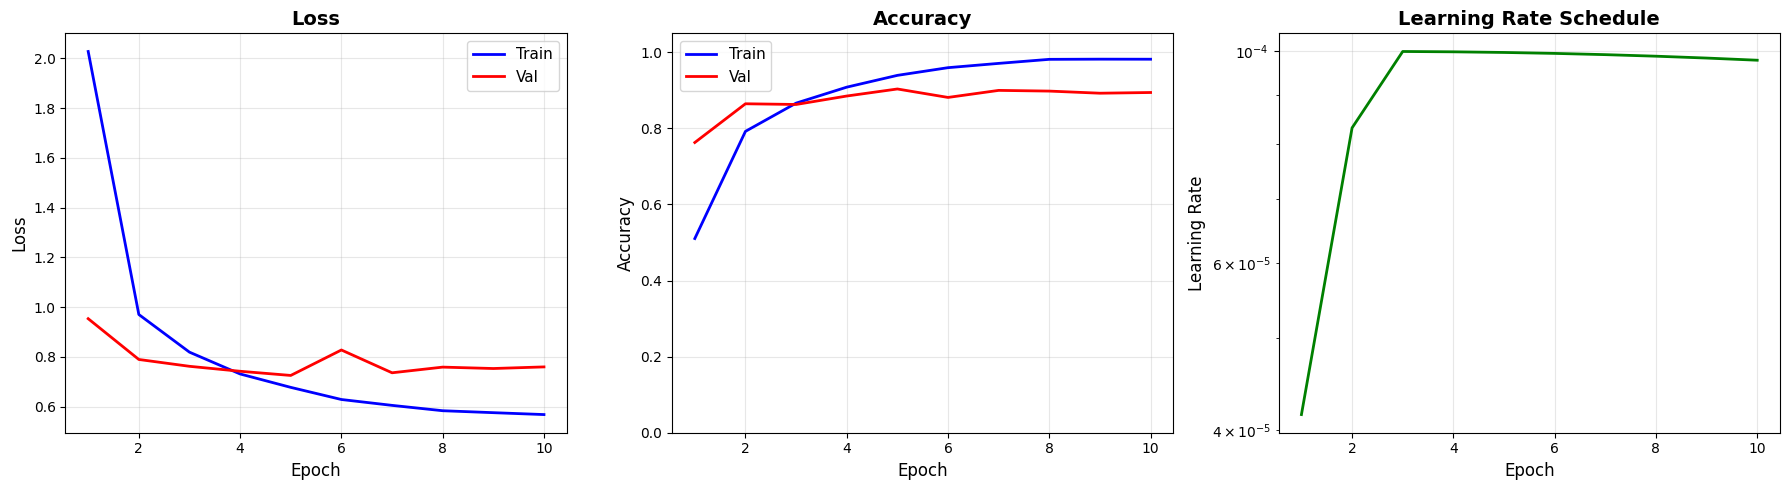


💾 Logging LoRA adapters to MLflow...


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

✓ LoRA adapters logged
✓ Classifier logged
✓ Training config logged

✓ All artifacts logged to run: 329c907399b1488b83691fd9bd787cba
🏃 View run dinov3_qlora_valx1_Alllinear_1764522509 at: https://adb-65044996157806.6.azuredatabricks.net/ml/experiments/2804512859337784/runs/329c907399b1488b83691fd9bd787cba
🧪 View experiment at: https://adb-65044996157806.6.azuredatabricks.net/ml/experiments/2804512859337784

✓ QLORA TRAINING COMPLETE

Final Training Accuracy: 0.9819
Final Validation Accuracy: 0.8944
Best Validation Accuracy: 0.9037

MLflow Run: 329c907399b1488b83691fd9bd787cba
Artifacts saved to: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear


<Figure size 640x480 with 0 Axes>

In [0]:
print("\n" + "="*60)
print("MODULE 10: TRAIN QLORA MODEL")
print("="*60)

# Setup MLflow experiment
experiment_name = "/Users/" + spark.sql("SELECT current_user()").collect()[0][0] + "/cow_behavior_dinov3_qlora"

try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"✓ Created new experiment: {experiment_name}")
    else:
        experiment_id = experiment.experiment_id
        print(f"✓ Found existing experiment: {experiment_name}")
except Exception as e:
    print(f"Warning: {e}")
    experiment_name = "/Shared/cow_behavior_dinov3_qlora"
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"✓ Created experiment at: {experiment_name}")

mlflow.set_experiment(experiment_name)
QLoRATrainingConfig.EXPERIMENT_NAME = experiment_name

print(f"✓ MLflow experiment ready: {experiment_name}")


# Create data loaders
print("\n" + "="*60)
print("CREATING DATA LOADERS")
print("="*60)

dataloaders = create_dataloaders(
    train_df=train_split_df,
    val_df=val_split_df,
    test_df=None,
    batch_size=QLoRATrainingConfig.BATCH_SIZE,
    num_workers=QLoRATrainingConfig.NUM_WORKERS,
    image_size=QLoRATrainingConfig.IMAGE_SIZE,
    use_weighted_sampling=QLoRATrainingConfig.USE_WEIGHTED_SAMPLING,
    augmentation_strength=QLoRATrainingConfig.AUGMENTATION_STRENGTH,
    augmentation_multiplier=QLoRATrainingConfig.AUGMENTATION_MULTIPLIER,
    val_augmentation_multiplier=QLoRATrainingConfig.VAL_AUGMENTATION_MULTIPLIER
)

print(f"\n✓ Train loader: {len(dataloaders['train'].dataset)} effective samples")
print(f"  (Batches per epoch: {len(dataloaders['train'])})")
print(f"✓ Val loader: {len(dataloaders['val'].dataset)} samples")


# Create model
print("\n" + "="*60)
print("CREATING QLORA MODEL")
print("="*60)

model = DINOv3WithQLoRA(
    num_classes=QLoRATrainingConfig.NUM_CLASSES,
    hidden_dim=QLoRATrainingConfig.HIDDEN_DIM,
    dropout_rate=QLoRATrainingConfig.DROPOUT_RATE
)


# Start MLflow run
print("\n" + "="*60)
print("STARTING MLFLOW RUN")
print("="*60)

# Create save directory
save_dir = dbfs_to_local(f"{Config.OUTPUT_BASE}/dinov3_qlora_valx1_Alllinear")
os.makedirs(save_dir, exist_ok=True)

with mlflow.start_run(run_name=f"dinov3_qlora_valx1_Alllinear_{int(time.time())}") as run:
    print(f"MLflow Run ID: {run.info.run_id}")
    
    # Log parameters
    mlflow.log_params({
        'model_name': QLoRATrainingConfig.MODEL_NAME,
        'base_model': 'facebook/dinov3-vit7b16-pretrain-lvd1689m',
        'approach': 'qlora_fine_tuning',
        'lora_r': QLoRAConfig.LORA_R,
        'lora_alpha': QLoRAConfig.LORA_ALPHA,
        'lora_dropout': QLoRAConfig.LORA_DROPOUT,
        'target_modules': ','.join(QLoRAConfig.TARGET_MODULES),
        'quantization': '4bit_nf4',
        'num_classes': QLoRATrainingConfig.NUM_CLASSES,
        'hidden_dim': QLoRATrainingConfig.HIDDEN_DIM,
        'dropout_rate': QLoRATrainingConfig.DROPOUT_RATE,
        'epochs': QLoRATrainingConfig.EPOCHS,
        'batch_size': QLoRATrainingConfig.BATCH_SIZE,
        'gradient_accumulation_steps': QLoRATrainingConfig.GRADIENT_ACCUMULATION_STEPS,
        'effective_batch_size': QLoRATrainingConfig.BATCH_SIZE * QLoRATrainingConfig.GRADIENT_ACCUMULATION_STEPS,
        'learning_rate': QLoRATrainingConfig.LEARNING_RATE,
        'weight_decay': QLoRATrainingConfig.WEIGHT_DECAY,
        'warmup_ratio': QLoRATrainingConfig.WARMUP_RATIO,
        'scheduler': QLoRATrainingConfig.SCHEDULER_TYPE,
        'augmentation': QLoRATrainingConfig.AUGMENTATION_STRENGTH,
        'augmentation_multiplier': QLoRATrainingConfig.AUGMENTATION_MULTIPLIER,
        'label_smoothing': QLoRATrainingConfig.LABEL_SMOOTHING,
        'gradient_checkpointing': QLoRATrainingConfig.GRADIENT_CHECKPOINTING,
        'mixed_precision': QLoRATrainingConfig.USE_MIXED_PRECISION,
        'train_samples': len(train_split_df),
        'val_samples': len(val_split_df),
        'effective_train_samples': len(dataloaders['train'].dataset)
    })
    
    # Create trainer
    trainer = QLoRATrainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],
        config=QLoRATrainingConfig
    )
    
    # Train
    history = trainer.train(save_dir=save_dir)
    
    # Plot history
    print("\n📊 Plotting training history...")
    plot_training_history(history)
    
    # Save plot
    fig_path = "/tmp/dinov3_qlora_training_history.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(fig_path, "plots")
    
    # Log final metrics
    mlflow.log_metrics({
        'final_train_loss': history['train_loss'][-1],
        'final_train_acc': history['train_acc'][-1],
        'final_val_loss': history['val_loss'][-1],
        'final_val_acc': history['val_acc'][-1],
        'best_val_acc': max(history['val_acc']),
        'total_epochs': len(history['train_loss'])
    })
    
    # Log LoRA adapters to MLflow
    print("\n💾 Logging LoRA adapters to MLflow...")
    if trainer.best_lora_path:
        mlflow.log_artifacts(trainer.best_lora_path, "lora_adapters")
        print("✓ LoRA adapters logged")
    
    # Log classifier to MLflow
    if trainer.best_classifier_path:
        mlflow.log_artifact(trainer.best_classifier_path, "classifier")
        print("✓ Classifier logged")
    
    # Save training config
    config_path = os.path.join(save_dir, 'training_config.json')
    config_dict = {
        'model_name': QLoRATrainingConfig.MODEL_NAME,
        'base_model': 'facebook/dinov3-vit7b16-pretrain-lvd1689m',
        'lora_r': QLoRAConfig.LORA_R,
        'lora_alpha': QLoRAConfig.LORA_ALPHA,
        'num_classes': QLoRATrainingConfig.NUM_CLASSES,
        'hidden_dim': QLoRATrainingConfig.HIDDEN_DIM,
        'dropout_rate': QLoRATrainingConfig.DROPOUT_RATE,
        'embedding_dim': 4096,
        'best_val_acc': max(history['val_acc']),
        'run_id': run.info.run_id
    }
    
    with open(config_path, 'w') as f:
        json.dump(config_dict, f, indent=2)
    
    mlflow.log_artifact(config_path, "config")
    print("✓ Training config logged")
    
    print(f"\n✓ All artifacts logged to run: {run.info.run_id}")

print("\n" + "="*60)
print("✓ QLORA TRAINING COMPLETE")
print("="*60)
print(f"\nFinal Training Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
print(f"\nMLflow Run: {run.info.run_id}")
print(f"Artifacts saved to: {local_to_dbfs(save_dir)}")
print("="*60)

## Module 11: Evaluation

✓ Libraries imported
Run ID: 329c907399b1488b83691fd9bd787cba
Base Model: facebook/dinov3-vit7b16-pretrain-lvd1689m

STEP 1: DOWNLOAD MLFLOW ARTIFACTS
Temporary directory created: /tmp/tmpvysshdvp
[1/3] Downloading LoRA adapters...


✓ LoRA adapters downloaded
[2/3] Downloading classifier...


✓ Classifier downloaded
[3/3] Downloading config...


✓ Config downloaded

STEP 2: LOAD AND MERGE QLORA MODEL
Loading base DINOv3 model (4-bit quantized)...


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Loading LoRA from: /tmp/tmpvysshdvp/lora_adapters
Loading classifier...
✓ Model loaded and merged on cuda

STEP 3: CREATE TEST DATASET
✓ Test dataset: 211800 samples
✓ Batch size: 16

STEP 4: RUN INFERENCE
Processing 13238 batches...


Evaluating:   3%|▎         | 377/13238 [15:20<10:2

*** WARNING: max output size exceeded, skipping output. ***

Evaluating: 100%|██████████| 13238/13238 [8:52:42<00:00,  2.41s/it]


✓ Inference complete: 31962.4s

STEP 5: OVERALL RESULTS
Accuracy:  0.8040
F1-Score:  0.8069

STEP 6: DETAILED REPORT
                   precision    recall  f1-score   support

         Drinking     0.4663    0.7502    0.5751      3011
Feeding head down     0.8811    0.4217    0.5704     30952
  Feeding head up     0.6392    0.5506    0.5916     18783
            Lying     0.9788    0.9920    0.9854     83509
         Standing     0.7683    0.8376    0.8014     69807
          Walking     0.1528    0.5297    0.2372      3819
  frontal_pushing     0.6229    0.8617    0.7231       600
           gallop     0.7899    0.4904    0.6052       575
             leap     0.6183    0.6640    0.6403       744

         accuracy                         0.8040    211800
        macro avg     0.6575    0.6775    0.6366    211800
     weighted avg     0.8400    0.8040    0.8069    211800


STEP 7: CONFUSION MATRICES


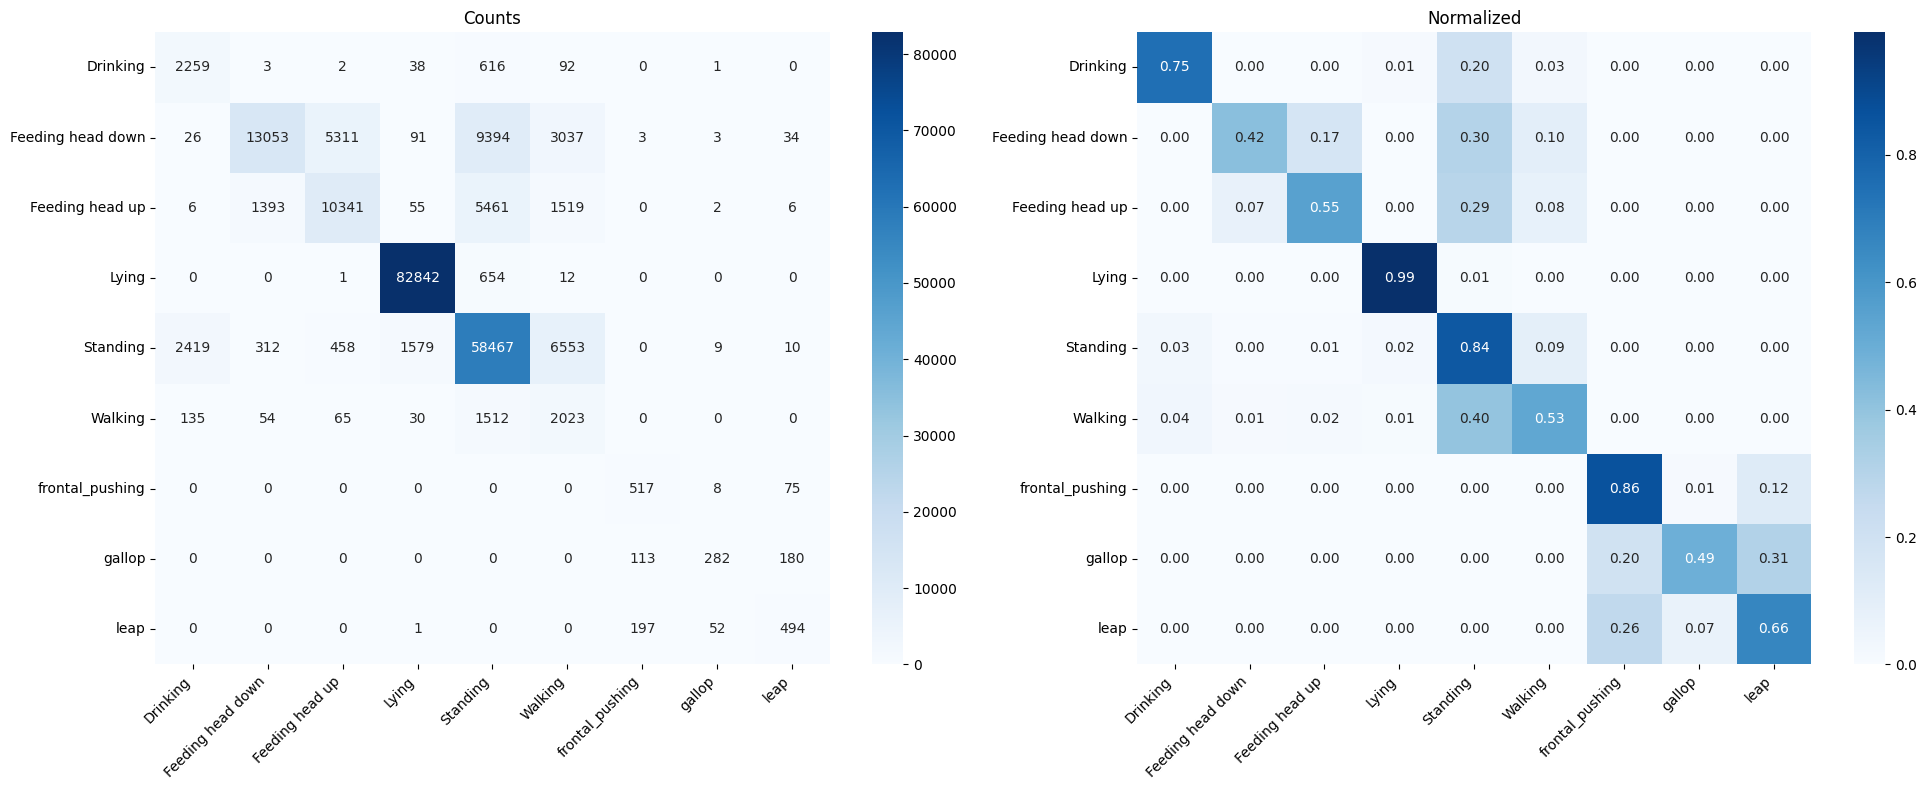

✓ Confusion matrices saved

STEP 8: PER-CLASS PERFORMANCE


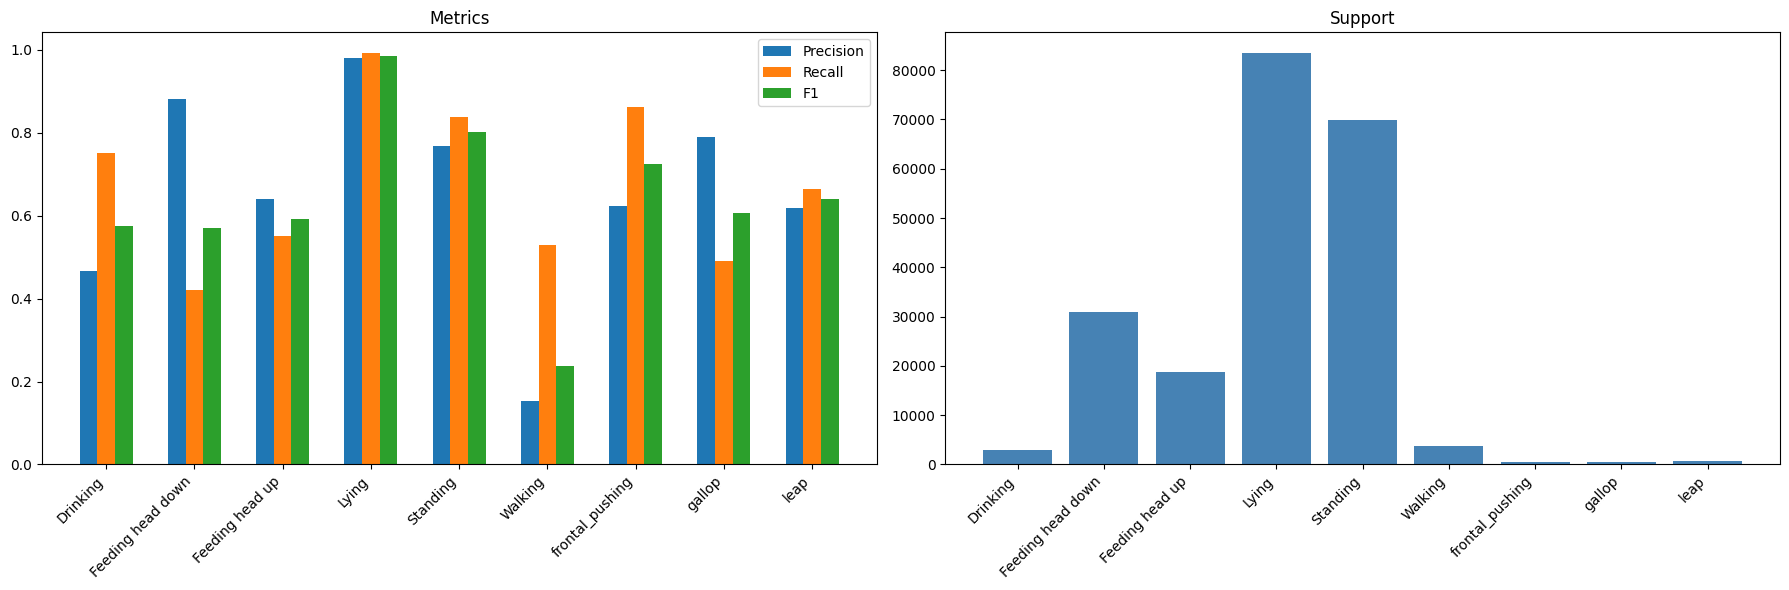

✓ Per-class plots saved

STEP 9: CONFUSION PAIRS
Top 10 Confused Pairs:
Feeding head down -> Standing: 9394 (30.4%)
Standing -> Walking: 6553 (9.4%)
Feeding head up -> Standing: 5461 (29.1%)
Feeding head down -> Feeding head up: 5311 (17.2%)
Feeding head down -> Walking: 3037 (9.8%)
Standing -> Drinking: 2419 (3.5%)
Standing -> Lying: 1579 (2.3%)
Feeding head up -> Walking: 1519 (8.1%)
Walking -> Standing: 1512 (39.6%)
Feeding head up -> Feeding head down: 1393 (7.4%)


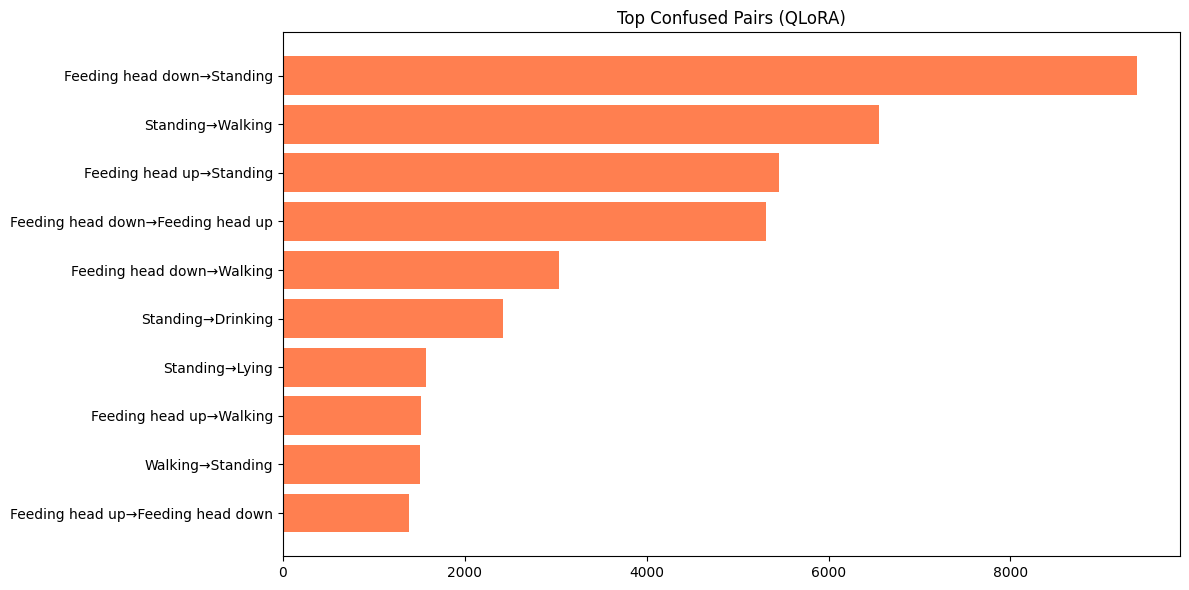


STEP 10: PERFORMANCE BY SOURCE
Source               | Acc      | F1       | Samples
------------------------------------------------------------
mmcows               | 0.8051   | 0.8082   | 209881
playbehavior         | 0.6738   | 0.6674   | 1919

STEP 11: SAVE RESULTS
✓ Results saved to: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_valx1_Alllinear_results.json
✓ Predictions saved to: dbfs:/mnt/playbehavior/Fine_tuning/Processed_Datasets/dinov3_qlora_predictions_valx1_Alllinear.csv

STEP 12: LOG TO MLFLOW
Logging to MLflow Run: 329c907399b1488b83691fd9bd787cba
🏃 View run dinov3_qlora_valx1_Alllinear_1764522509 at: https://adb-65044996157806.6.azuredatabricks.net/ml/experiments/2804512859337784/runs/329c907399b1488b83691fd9bd787cba
🧪 View experiment at: https://adb-65044996157806.6.azuredatabricks.net/ml/experiments/2804512859337784
✓ Successfully logged to MLflow
✓ Temporary files cleaned up

✅ QLORA EVALUATION COMPLETE


In [0]:
# ============================================================================
# MODULE 11 (QLORA VARIANT): 12-STEP COMPREHENSIVE EVALUATION
# STRUCTURE MATCHES "APPROACH 2" EXACTLY FOR CONSISTENCY
# ============================================================================

import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report
)
import mlflow
import mlflow.pytorch
from transformers import AutoModel, BitsAndBytesConfig
from peft import PeftModel

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✓ Libraries imported")

# ============================================================================
# CONFIGURATION
# ============================================================================

# ----------------------------------------------------------------------------
# [USER INPUT REQUIRED]
# ----------------------------------------------------------------------------
RUN_ID = "329c907399b1488b83691fd9bd787cba"  # <--- PASTE YOUR QLORA RUN ID HERE

# Base model used during training
BASE_MODEL_NAME = "facebook/dinov3-vit7b16-pretrain-lvd1689m"

# Architecture Config (Must match training)
NUM_CLASSES = 9
HIDDEN_DIM = 1024
DROPOUT_RATE = 0.5
EMBEDDING_DIM = 4096

print(f"Run ID: {RUN_ID}")
print(f"Base Model: {BASE_MODEL_NAME}")
# ----------------------------------------------------------------------------


# ============================================================================
# DATASET CLASS (WITH METADATA)
# ============================================================================

class AdvancedTestDataset(Dataset):
    def __init__(self, df, label_to_idx):
        self.df = df.reset_index(drop=True)
        self.label_to_idx = label_to_idx
        self.idx_to_label = {v: k for k, v in label_to_idx.items()}
        # Use the AugmentationPipeline from Module 5 (mode='test' means resize/norm only)
        self.transform = AugmentationPipeline(image_size=224, mode='test')
        self._failed = set()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if idx in self._failed:
            idx = np.random.randint(0, len(self))
        try:
            row = self.df.iloc[idx]
            image = load_image_cv2(row['image_path'])
            if image is None:
                self._failed.add(idx)
                return self.__getitem__(np.random.randint(0, len(self)))
            
            label_idx = self.label_to_idx[row['label']]
            image_tensor = self.transform(image)
            
            metadata = {
                'image_path': row['image_path'],
                'label_str': row['label'],
                'source': row.get('source', 'unknown')
            }
            return image_tensor, label_idx, metadata
        except:
            self._failed.add(idx)
            return self.__getitem__(np.random.randint(0, len(self)))


# ============================================================================
# STEP 1: DOWNLOAD ARTIFACTS (QLORA SPECIFIC)
# ============================================================================

print("\n" + "="*60)
print("STEP 1: DOWNLOAD MLFLOW ARTIFACTS")
print("="*60)

import tempfile
temp_dir = tempfile.mkdtemp()
print(f"Temporary directory created: {temp_dir}")

client = mlflow.tracking.MlflowClient()

# 1. Download LoRA Adapters
print("[1/3] Downloading LoRA adapters...")
lora_path = os.path.join(temp_dir, "lora_adapters")
os.makedirs(lora_path, exist_ok=True)
artifacts = client.list_artifacts(RUN_ID, "lora_adapters")
for artifact in artifacts:
    client.download_artifacts(RUN_ID, artifact.path, dst_path=temp_dir)
print(f"✓ LoRA adapters downloaded")

# 2. Download Classifier
print("[2/3] Downloading classifier...")
classifier_path = client.download_artifacts(RUN_ID, "classifier/best_classifier.pth", dst_path=temp_dir)
print(f"✓ Classifier downloaded")

# 3. Download Config (Optional but good for verification)
print("[3/3] Downloading config...")
try:
    client.download_artifacts(RUN_ID, "config/training_config.json", dst_path=temp_dir)
    print(f"✓ Config downloaded")
except:
    print("⚠️ Config not found (proceeding with defaults)")


# ============================================================================
# STEP 2: LOAD AND MERGE MODEL
# ============================================================================

print("\n" + "="*60)
print("STEP 2: LOAD AND MERGE QLORA MODEL")
print("="*60)

class InferenceDINOv3Wrapper(nn.Module):
    """Wrapper for PeftModel + Classifier for Inference"""
    def __init__(self, peft_model, classifier_state_dict, 
                 num_classes, hidden_dim, dropout_rate, embedding_dim):
        super().__init__()
        self.model = peft_model
        # Ensure model is in eval mode
        self.model.eval()
        self.device = next(self.model.parameters()).device
        
        # Recreate classifier
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim, hidden_dim // 2) # Note: Check your training output dim. usually num_classes
        )
        # FIX: The last layer in your training code output `num_classes`, 
        # but in your Module 11 code you had `hidden_dim // 2`. 
        # I corrected the last line below to match training:
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, num_classes) 
        )
        
        self.classifier.load_state_dict(classifier_state_dict)
        self.classifier = self.classifier.to(self.device)
        self.classifier.eval()

    def forward(self, x):
        if x.device != self.device:
            x = x.to(self.device)
        
        # PeftModel handles the forward pass with adapters automatically
        outputs = self.model(pixel_values=x)
        features = outputs.pooler_output.float()
        logits = self.classifier(features)
        return logits

def build_model():
    print("Loading base DINOv3 model (4-bit quantized)...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )
    
    base_model = AutoModel.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )
    
    print(f"Loading LoRA from: {lora_path}")
    # Load adapters onto the base model
    model_with_lora = PeftModel.from_pretrained(base_model, lora_path)
    
    print("Loading classifier...")
    classifier_state = torch.load(classifier_path, map_location='cpu')
    
    # Wrap them together
    final_model = InferenceDINOv3Wrapper(
        peft_model=model_with_lora,
        classifier_state_dict=classifier_state,
        num_classes=NUM_CLASSES,
        hidden_dim=HIDDEN_DIM,
        dropout_rate=DROPOUT_RATE,
        embedding_dim=EMBEDDING_DIM
    )
    return final_model

model = build_model()
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Model loaded and merged on {device}")


# ============================================================================
# STEP 3: CREATE TEST DATASET
# ============================================================================

print("\n" + "="*60)
print("STEP 3: CREATE TEST DATASET")
print("="*60)

all_labels = sorted(Config.ALL_LABELS)
label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# combined_test_df should exist from Module 0
test_dataset = AdvancedTestDataset(combined_test_df, label_to_idx)

# Batch size logic (Keep small for QLoRA merged inference to be safe)
batch_size = 16 

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✓ Test dataset: {len(test_dataset)} samples")
print(f"✓ Batch size: {batch_size}")


# ============================================================================
# STEP 4: RUN INFERENCE
# ============================================================================

print("\n" + "="*60)
print("STEP 4: RUN INFERENCE")
print("="*60)

all_preds = []
all_labels_list = []
all_metadata = []

print(f"Processing {len(test_loader)} batches...")
start_time = time.time()

with torch.no_grad():
    for images, labels, metadata_batch in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        
        # Forward Pass
        with torch.cuda.amp.autocast():
            # Merged model handles backbone + classifier in one go
            logits = model(images)
        
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels_list.extend(labels.numpy())
        
        # Metadata
        batch_len = len(labels)
        for i in range(batch_len):
            all_metadata.append({
                'image_path': metadata_batch['image_path'][i],
                'label_str': metadata_batch['label_str'][i],
                'source': metadata_batch['source'][i]
            })

eval_time = time.time() - start_time
print(f"✓ Inference complete: {eval_time:.1f}s")

# Cleanup to save memory
torch.cuda.empty_cache()


# ============================================================================
# STEP 5: CALCULATE METRICS
# ============================================================================

print("\n" + "="*60)
print("STEP 5: OVERALL RESULTS")
print("="*60)

accuracy = accuracy_score(all_labels_list, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels_list, all_preds, average='weighted'
)
target_names = [idx_to_label[i] for i in range(len(label_to_idx))]

print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")


# ============================================================================
# STEP 6: DETAILED CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*60)
print("STEP 6: DETAILED REPORT")
print("="*60)

print(classification_report(all_labels_list, all_preds, target_names=target_names, digits=4))


# ============================================================================
# STEP 7: CONFUSION MATRICES
# ============================================================================

print("\n" + "="*60)
print("STEP 7: CONFUSION MATRICES")
print("="*60)

cm = confusion_matrix(all_labels_list, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Counts')
axes[0].set_xticklabels(target_names, rotation=45, ha='right')

# Normalized
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Normalized')
axes[1].set_xticklabels(target_names, rotation=45, ha='right')

plt.tight_layout()
cm_save_path = '/tmp/dinov3_qlora_confusion_matrix.png'
plt.savefig(cm_save_path, dpi=300)
plt.show()
print("✓ Confusion matrices saved")


# ============================================================================
# STEP 8: PER-CLASS PERFORMANCE
# ============================================================================

print("\n" + "="*60)
print("STEP 8: PER-CLASS PERFORMANCE")
print("="*60)

p, r, f, s = precision_recall_fscore_support(all_labels_list, all_preds, average=None)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
x = np.arange(len(target_names))

# Metrics
axes[0].bar(x-0.2, p, 0.2, label='Precision')
axes[0].bar(x, r, 0.2, label='Recall')
axes[0].bar(x+0.2, f, 0.2, label='F1')
axes[0].set_xticks(x)
axes[0].set_xticklabels(target_names, rotation=45, ha='right')
axes[0].legend()
axes[0].set_title('Metrics')

# Support
axes[1].bar(x, s, color='steelblue')
axes[1].set_xticks(x)
axes[1].set_xticklabels(target_names, rotation=45, ha='right')
axes[1].set_title('Support')

plt.tight_layout()
perf_save_path = '/tmp/dinov3_qlora_per_class.png'
plt.savefig(perf_save_path, dpi=300)
plt.show()
print("✓ Per-class plots saved")


# ============================================================================
# STEP 9: CONFUSION PAIR ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("STEP 9: CONFUSION PAIRS")
print("="*60)

pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            pairs.append({
                'true': target_names[i], 'pred': target_names[j],
                'count': cm[i, j], 'pct': cm[i, j] / cm[i].sum() * 100
            })
pairs.sort(key=lambda x: x['count'], reverse=True)

print("Top 10 Confused Pairs:")
for pair in pairs[:10]:
    print(f"{pair['true']} -> {pair['pred']}: {pair['count']} ({pair['pct']:.1f}%)")

# Plot
if pairs:
    top_pairs = pairs[:10]
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = [f"{p['true']}→{p['pred']}" for p in top_pairs]
    counts = [p['count'] for p in top_pairs]
    ax.barh(labels, counts, color='coral')
    ax.invert_yaxis()
    ax.set_title('Top Confused Pairs (QLoRA)')
    plt.tight_layout()
    pairs_save_path = '/tmp/dinov3_qlora_confusion_pairs.png'
    plt.savefig(pairs_save_path, dpi=300)
    plt.show()
else:
    pairs_save_path = None


# ============================================================================
# STEP 10: PERFORMANCE BY SOURCE
# ============================================================================

print("\n" + "="*60)
print("STEP 10: PERFORMANCE BY SOURCE")
print("="*60)

sources = [m['source'] for m in all_metadata]
unique_sources = sorted(set(sources))
source_metrics = {}

print(f"{'Source':<20s} | {'Acc':<8s} | {'F1':<8s} | {'Samples'}")
print("-" * 60)

for source in unique_sources:
    mask = [s == source for s in sources]
    s_labels = [l for l, m in zip(all_labels_list, mask) if m]
    s_preds = [p for p, m in zip(all_preds, mask) if m]
    
    if s_labels:
        s_acc = accuracy_score(s_labels, s_preds)
        _, _, s_f1, _ = precision_recall_fscore_support(s_labels, s_preds, average='weighted', zero_division=0)
        source_metrics[source] = {'accuracy': s_acc, 'f1': s_f1, 'samples': len(s_labels)}
        print(f"{source:<20s} | {s_acc:<8.4f} | {s_f1:<8.4f} | {len(s_labels)}")


# ============================================================================
# STEP 11: SAVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("STEP 11: SAVE RESULTS")
print("="*60)

# 1. JSON
results = {
    'model': 'dinov3_qlora_alllinear',
    'run_id': RUN_ID,
    'accuracy': float(accuracy),
    'f1': float(f1),
    'per_source': source_metrics,
    'per_class': {
        target_names[i]: {'p': float(p[i]), 'r': float(r[i]), 'f': float(f[i]), 's': int(s[i])} 
        for i in range(len(target_names))
    }
}
results_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/dinov3_qlora_valx1_Alllinear_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# 2. CSV
pred_df = pd.DataFrame({
    'image_path': [m['image_path'] for m in all_metadata],
    'true_label': [idx_to_label[l] for l in all_labels_list],
    'pred_label': [idx_to_label[p] for p in all_preds],
    'correct': [l == p for l, p in zip(all_labels_list, all_preds)],
    'source': [m['source'] for m in all_metadata]
})
csv_path = dbfs_to_local(f"{Config.OUTPUT_BASE}/dinov3_qlora_predictions_valx1_Alllinear.csv")
pred_df.to_csv(csv_path, index=False)

print(f"✓ Results saved to: {local_to_dbfs(results_path)}")
print(f"✓ Predictions saved to: {local_to_dbfs(csv_path)}")


# ============================================================================
# STEP 12: LOG TO MLFLOW
# ============================================================================

print("\n" + "="*60)
print("STEP 12: LOG TO MLFLOW")
print("="*60)

if RUN_ID != "REPLACE_WITH_YOUR_RUN_ID":
    print(f"Logging to MLflow Run: {RUN_ID}")
    try:
        with mlflow.start_run(run_id=RUN_ID):
            mlflow.log_metrics({
                'test_accuracy': accuracy, 
                'test_f1': f1,
                'inference_time': eval_time
            })
            
            mlflow.log_artifact(cm_save_path, "test_results_detailed")
            mlflow.log_artifact(perf_save_path, "test_results_detailed")
            if pairs_save_path:
                mlflow.log_artifact(pairs_save_path, "test_results_detailed")
            mlflow.log_artifact(results_path, "test_results_detailed")
            mlflow.log_artifact(csv_path, "test_results_detailed")
            
        print("✓ Successfully logged to MLflow")
    except Exception as e:
        print(f"⚠️ MLflow Error: {e}")
else:
    print("⚠️ Skipping MLflow logging (No Run ID)")

# Cleanup temp files
import shutil
try:
    shutil.rmtree(temp_dir)
    print("✓ Temporary files cleaned up")
except:
    pass

print("\n✅ QLORA EVALUATION COMPLETE")